<a href="https://colab.research.google.com/github/hunarpreet1/TradeAnomaly/blob/main/PriceVolumneAnomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [56]:
!pip install ta
import ta

In [57]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date

folder_path = '/content/drive/My Drive/PriceData'

In [77]:
priceData = pd.read_csv(folder_path + '/' + 'pricedata.csv')
universe = pd.read_csv(folder_path + '/' + 'nse200universe.csv')
nifty50 = pd.read_csv(folder_path + '/' + 'NiftyTRI_Index.csv')
nifty200 = pd.read_csv(folder_path + '/' + 'NSE200TRI_Index.csv')

In [ ]:
universe.dropna()

In [78]:
# around 3% data has volume missing
# around 0.1% data has price missing
priceData.set_index('date', inplace=True)
nifty50.set_index('date', inplace=True)
nifty200.set_index('date', inplace=True)

priceData.index = pd.to_datetime(priceData.index)
nifty50.index = pd.to_datetime(nifty50.index)
nifty200.index = pd.to_datetime(nifty200.index)

priceData.dropna(inplace=True) # Think about Nans later.....
nifty50.fillna(method="ffill", inplace=True)
nifty50.fillna(method="bfill", inplace=True)

nifty200.fillna(method="ffill", inplace=True)
nifty200.fillna(method="bfill", inplace=True) # can fill same as PX_LAST ????

<ipython-input-78-d6cb5e96baa2>:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nifty50.fillna(method="ffill", inplace=True)
<ipython-input-78-d6cb5e96baa2>:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nifty50.fillna(method="bfill", inplace=True)
<ipython-input-78-d6cb5e96baa2>:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nifty200.fillna(method="ffill", inplace=True)
<ipython-input-78-d6cb5e96baa2>:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nifty200.fillna(method="bfill", inplace=True)


<Axes: xlabel='date'>

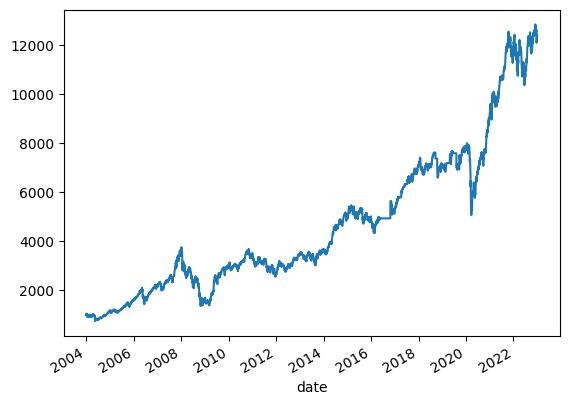

In [80]:
nifty200['PX_HIGH'].plot() # Many missing non close values

In [99]:
priceData["totalVolume"] = priceData.groupby(level=0)["PX_VOLUME"].transform("sum")
priceData["maxStockVolume"] = priceData.groupby(level=0)["PX_VOLUME"].transform("max")
priceData["volume_ratio"] = priceData["PX_VOLUME"] / priceData["totalVolume"]
priceData["volume_max_ratio"] = priceData["PX_VOLUME"] / priceData["maxStockVolume"]

priceData['returnsOpen'] = priceData.groupby('security')['PX_OPEN'].pct_change()
priceData['returnsClose'] = priceData.groupby('security')['PX_LAST'].pct_change()
priceData['returnsHigh'] = priceData.groupby('security')['PX_HIGH'].pct_change()
priceData['returnsLow'] = priceData.groupby('security')['PX_LOW'].pct_change()
priceData.dropna(inplace=True) # Think about Nans later.....

#Extract candle stick/technical features

> Add blockquote



In [88]:
import pandas as pd
import numpy as np
import ta

import pandas as pd

def calculate_mfi(df, period=14, high_col="PX_HIGH", low_col="PX_LOW", close_col="PX_LAST", volume_col="PX_VOLUME", epsilon=1e-6):
    """
    Calculate Money Flow Index (MFI).

    Parameters:
    df (pd.DataFrame): DataFrame with OHLCV data.
    period (int): Lookback period for MFI (default=14).
    high_col, low_col, close_col, volume_col (str): Column names for high, low, close, and volume.

    Returns:
    pd.Series: Money Flow Index values.
    """
    # Typical Price
    df["TP"] = (df[high_col] + df[low_col] + df[close_col]) / 3

    # Money Flow
    df["MF"] = df["TP"] * df[volume_col]

    # Positive & Negative Money Flow
    df["Positive MF"] = df["MF"].where(df["TP"].diff() > 0, 0)
    df["Negative MF"] = df["MF"].where(df["TP"].diff() < 0, 0)

    # Money Flow Ratio
    df["MFR"] = df["Positive MF"].rolling(window=period).sum() / (df["Negative MF"].rolling(window=period).sum() + epsilon)


    # Money Flow Index
    df["MFI"] = 100 - (100 / (1 + df["MFR"]))

    return df["MFI"]

def extract_features(df):
    """
    Extracts technical features from OHLCV (PX_OPEN, PX_HIGH, PX_LOW, PX_LAST, PX_VOLUME) data.

    Parameters:
    df (pd.DataFrame): DataFrame with columns ['Date', 'security', 'PX_OPEN', 'PX_HIGH', 'PX_LOW', 'PX_LAST', 'PX_VOLUME'].

    Returns:
    pd.DataFrame: DataFrame with added feature columns.
    """
    df = df.copy()

    # === Basic Price Features ===
    df["Daily_Return"] = df.groupby("security")["PX_LAST"].pct_change()
    #df["Log_Return"] = df.groupby("security")["PX_LAST"].apply(lambda x: np.log(x / x.shift(1)))
    df["Price_Spread"] = df["PX_HIGH"] - df["PX_LOW"]
    df["Body_Size"] = abs(df["PX_LAST"] - df["PX_OPEN"])
    df["Upper_Shadow"] = df["PX_HIGH"] - df[["PX_OPEN", "PX_LAST"]].max(axis=1)
    df["Lower_Shadow"] = df[["PX_OPEN", "PX_LAST"]].min(axis=1) - df["PX_LOW"]
    df["Close_Open_Gap"] = (df["PX_OPEN"] - df.groupby("security")["PX_LAST"].shift(1)) / df.groupby("security")["PX_LAST"].shift(1)
    df["Volume_Change"] = df.groupby("security")["PX_VOLUME"].pct_change()

    # === Trend Indicators ===
    df["SMA_5"] = df.groupby("security")["PX_LAST"].transform(lambda x: x.rolling(5).mean())
    df["SMA_20"] = df.groupby("security")["PX_LAST"].transform(lambda x: x.rolling(20).mean())
    df["EMA_12"] = ta.trend.EMAIndicator(df["PX_LAST"], window=12).ema_indicator()
    df["EMA_26"] = ta.trend.EMAIndicator(df["PX_LAST"], window=26).ema_indicator()
    df["MACD"] = ta.trend.MACD(df["PX_LAST"]).macd()
    df["MACD_Signal"] = ta.trend.MACD(df["PX_LAST"]).macd_signal()
    df["RSI"] = ta.momentum.RSIIndicator(df["PX_LAST"], window=14).rsi()

    # === Volatility Indicators ===
    df["ATR"] = ta.volatility.AverageTrueRange(df["PX_HIGH"], df["PX_LOW"], df["PX_LAST"], window=14).average_true_range()
    bollinger = ta.volatility.BollingerBands(df["PX_LAST"], window=20, window_dev=2)
    df["Bollinger_Upper"] = bollinger.bollinger_hband()
    df["Bollinger_Lower"] = bollinger.bollinger_lband()
    #df["Historical_Volatility"] = df.groupby("security")["Log_Return"].transform(lambda x: x.rolling(20).std())

    # === Momentum Indicators ===
    df["Momentum_5"] = ta.momentum.ROCIndicator(df["PX_LAST"], window=5).roc()
    df["Williams_%R"] = ta.momentum.WilliamsRIndicator(df["PX_HIGH"], df["PX_LOW"], df["PX_LAST"], lbp=14).williams_r()

    # Money Flow Index
    df["MFI"] = calculate_mfi(df)

    return df

# === Apply Feature Extraction to Dataset ===
priceData = extract_features(priceData)  # df contains multiple securities
priceData.dropna(inplace=True)

NameError: name 'df_features' is not defined

In [61]:
def getStockPriceVolumeData(ticker, start=None, end=None):
  stock_data = priceData[priceData['security'] == ticker + IN_EQUITY_PREFIX]
  if start is not None:
    stock_data = stock_data.loc[start:]
  if end is not None:
    stock_data = stock_data.loc[:end]
  return stock_data

def plotPrice(ticker, priceType='PX_OPEN', start=None, end=None, dotDates=None, lineDates=None, saveFig=True, saveSuffix=''):
  df = getStockPriceVolumeData(ticker, start=start, end=end)
  plt.close("all")  # Close any previous plots
  fig, ax = plt.subplots(figsize=(10, 5))  # Create a new figure explicitly

  ax.plot(df.index, df[priceType], label=priceType, color='black')

  # Formatting
  ax.set_xlabel("Date")
  ax.set_ylabel(priceType)
  ax.set_title(ticker)
  ax.legend()
  plt.xticks(rotation=45)
  plt.grid()
  ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically adjusts date labels
  fig.autofmt_xdate()  # Rotates dates for better readability
  start = pd.Timestamp(start) if start is not None else df.index[0]
  end = pd.Timestamp(end) if end is not None else df.index[-1]

  if dotDates is not None:
    dotDates = [date for date in dotDates if date >= start and date <= end]
    plt.scatter(dotDates, df.loc[dotDates, priceType], color='red', zorder=3, label="Dots")

  if lineDates is not None:
    lineDates = [pd.Timestamp(date) for date in lineDates if start <= pd.Timestamp(date) <= end]
    print(lineDates)
    for date in lineDates:
        plt.axvline(x=date, color='blue', linestyle='--', linewidth=1, alpha=0.7, label="Event" if date == lineDates[0] else "")

  if saveFig:
    plt.savefig(ticker + '_' + saveSuffix + '.png', bbox_inches="tight")
    #print(f"Plot saved to {save_path}")

  plt.show()

#Remove Index component from stock price

In [62]:
IN_EQUITY_PREFIX = ' IN Equity'
CURR_UNIVERSE = [ ticker.split(' ')[0] for ticker in universe['2022-12-30'] if pd.notna(ticker) ]

In [63]:
import pandas as pd
import numpy as np

def extend_index_composition(index_composition_df):
    """
    Extend index composition backward in time before the first available date.
    Uses the earliest available composition for all prior dates.

    Parameters:
    index_composition_df (pd.DataFrame): Index components with dates as columns and tickers as values.

    Returns:
    pd.DataFrame: Extended index composition.
    """
    first_date = index_composition_df.columns.min()  # Find earliest available date
    all_dates = pd.date_range(start=price_df.index.min(), end=index_composition_df.columns.max(), freq="B")  # All business days

    # Convert composition to DataFrame with dates as index
    extended_composition = index_composition_df.T
    extended_composition = extended_composition.reindex(all_dates, method="ffill")  # Fill backward before 2012

    return extended_composition.T  # Convert back to original format

def compute_equal_weighted_index_returns(price_df, index_composition_df):
    """
    Compute equal-weighted index returns using daily stock prices and index composition.

    Parameters:
    price_df (pd.DataFrame): OHLCV data with date index and tickers as columns (PX_LAST values).
    index_composition_df (pd.DataFrame): Index components with dates as columns and tickers as values.

    Returns:
    pd.Series: Equal-weighted index returns over time.
    """
    # Extend composition before 2012
    index_composition_df = extend_index_composition(index_composition_df) # check with Anay on composition data before 2012....

    returns = price_df.pct_change()  # Compute daily simple returns
    index_returns = {}

    for date in index_composition_df.columns:  # Loop through each date
        if date not in returns.index:
            continue  # Skip if no return data

        tickers = index_composition_df[date].dropna().values  # Get tickers for that day
        valid_returns = returns.loc[date, tickers].dropna()  # Get valid returns

        if len(valid_returns) > 0:
            index_returns[date] = valid_returns.mean()  # Compute equal-weighted return

    return pd.Series(index_returns, name="Equal_Weighted_Return")

# Example Usage
index_composition_df = extend_index_composition(index_composition_df)  # Extend composition first
equal_weighted_index_returns = compute_equal_weighted_index_returns(price_df, index_composition_df)


NameError: name 'index_composition_df' is not defined

In [81]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import probplot
import logging
from datetime import datetime

def compute_log_returns(df):
    """ Compute log returns for a given price series. """
    return np.log(df / df.shift(1))

def compute_simple_returns(df):
    """ Compute simple returns for a given price series. """
    return df.pct_change()

def setup_logger(log_file='idiosyncratic_returns.log'):
    """Configure logging system"""
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(log_file),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger()

def compute_idiosyncratic_returns(priceData, indexData, price_types=['PX_LAST', 'PX_OPEN', 'PX_HIGH', 'PX_LOW'],
                                universe=None, make_plots=False, merge_to_original=True,
                                log_stats=True, log_file='idiosyncratic_returns.log'):
    """
    Compute idiosyncratic returns with enhanced logging functionality.

    Parameters:
    priceData (pd.DataFrame): Original price data indexed by date with columns ['security', ...]
    indexData (pd.DataFrame): Index prices with matching price types, indexed by date
    price_types (list): Price columns to process
    universe (list): Securities to process (None=all available)
    make_plots (bool): Generate diagnostic plots
    merge_to_original (bool): Whether to merge results back to priceData
    log_stats (bool): Whether to log regression statistics
    log_file (str): Path to log file

    Returns:
    pd.DataFrame or dict: If merge_to_original=True returns enhanced DataFrame,
                         else returns dictionary of idiosyncratic returns
    """
    # Initialize logger
    logger = setup_logger(log_file)
    logger.info("Starting idiosyncratic returns computation")
    logger.info(f"Processing {len(price_types)} price types: {', '.join(price_types)}")

    # Set default universe if not provided
    if universe is None:
        universe = priceData['security'].unique()
        logger.info(f"Using default universe of {len(universe)} securities")
    else:
        logger.info(f"Processing custom universe of {len(universe)} securities")

    # Initialize storage
    idio_dict = {pt: {} for pt in price_types}
    results = priceData.copy() if merge_to_original else None
    stats_records = []

    # Verify index price types
    missing_types = [pt for pt in price_types if pt not in indexData.columns]
    if missing_types:
        error_msg = f"Index data missing price types: {missing_types}"
        logger.error(error_msg)
        raise ValueError(error_msg)
    else:
        logger.info("All required price types present in index data")

    # Precompute index returns
    index_returns = {pt: compute_log_returns(indexData[pt]).dropna()
                    for pt in price_types}
    logger.info("Precomputed index returns for all price types")

    processed = 0
    for security in universe:
        try:
            sec_data = getStockPriceVolumeData(security)
            if sec_data is None or sec_data.empty:
                logger.warning(f"No data available for security: {security}")
                continue

            for price_type in price_types:
                if price_type not in sec_data.columns:
                    logger.debug(f"Price type {price_type} not found for {security}")
                    continue

                # Calculate returns and align data
                stock_returns = compute_log_returns(sec_data[price_type]).dropna()

                # Store log returns in results DataFrame
                if merge_to_original:
                  valid_indices = stock_returns.index.intersection(results.index)
                  log_return_col = f"LOGRET_{price_type}"
                  mask = (results['security'] == security + IN_EQUITY_PREFIX) & (results.index.isin(valid_indices))
                  results.loc[mask, log_return_col] = stock_returns.loc[valid_indices].values

                aligned_data = pd.concat([stock_returns, index_returns[price_type]],
                                       axis=1, join="inner").dropna()
                aligned_data.columns = ['stock_return', 'index_return']

                if len(aligned_data) < 30:
                    logger.warning(f"Insufficient data points ({len(aligned_data)}) for {security} {price_type}")
                    continue

                # Run regression
                X = sm.add_constant(aligned_data['index_return'])
                y = aligned_data['stock_return']
                model = sm.OLS(y, X).fit()
                residuals = y - model.predict(X)
                print(f"{security}_{price_type} Regression Finished | R² = {model.rsquared:.4f}")

                # Store results
                idio_dict[price_type][security] = residuals
                processed += 1

                # Log regression statistics
                if log_stats:
                    stats_records.append({
                        'security': security,
                        'price_type': price_type,
                        'alpha': model.params[0],
                        'beta': model.params[1],
                        'r_squared': model.rsquared,
                        'observations': len(aligned_data)
                    })

                # Merge if requested
                if merge_to_original:
                    valid_indices = residuals.index.intersection(results.index)
                    col_name = f"IDIO_{price_type}"
                    mask = (results['security'] == security + IN_EQUITY_PREFIX) & (results.index.isin(valid_indices))
                    results.loc[mask, col_name] = residuals.loc[valid_indices].values

                # Generate plots if requested
                if make_plots:
                    generate_regression_plots(aligned_data, model, residuals, security, price_type)

        except Exception as e:
            logger.error(f"Error processing {security}: {str(e)}", exc_info=True)
            continue

    # Final logging summary
    logger.info(f"Completed processing. Successfully processed {processed} security/price-type combinations")

    return results if merge_to_original else idio_dict

def generate_regression_plots(aligned_data, model, residuals, security, price_type):
    """Helper function to generate diagnostic plots."""
    plt.figure(figsize=(15, 12))
    plt.suptitle(f"{security} - {price_type} Regression Diagnostics", y=1.02)

    plt.subplot(2, 2, 1)
    sns.regplot(x='index_return', y='stock_return', data=aligned_data,
                scatter_kws={"alpha": 0.5}, line_kws={"color": "red"}, ci=None)
    plt.xlabel(f"Index {price_type} Returns")
    plt.ylabel(f"Stock {price_type} Returns")
    plt.grid(True)

    plt.subplot(2, 2, 2)
    sns.histplot(residuals, bins=50, kde=True)
    plt.axvline(0, color="red", linestyle="--")
    plt.grid(True)

    plt.subplot(2, 2, 3)
    probplot(residuals, dist="norm", plot=plt)
    plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.scatter(model.predict(), residuals, alpha=0.5)
    plt.axhline(0, color="red", linestyle="--")
    plt.grid(True)

    plt.tight_layout()
    plt.show()


priceData = compute_idiosyncratic_returns(priceData, nifty200, universe=CURR_UNIVERSE, merge_to_original=True)

ABB_PX_LAST Regression Finished | R² = 0.2634
ABB_PX_OPEN Regression Finished | R² = 0.0163
ABB_PX_HIGH Regression Finished | R² = 0.0710
ABB_PX_LOW Regression Finished | R² = 0.1368


<ipython-input-81-100154a856fb>:128: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'alpha': model.params[0],
<ipython-input-81-100154a856fb>:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'beta': model.params[1],
<ipython-input-81-100154a856fb>:128: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'alpha': model.params[0],
<ipython-input-81-100154a856fb>:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecate

ABCAP_PX_LAST Regression Finished | R² = 0.2923
ABCAP_PX_OPEN Regression Finished | R² = 0.0186
ABCAP_PX_HIGH Regression Finished | R² = 0.0636
ABCAP_PX_LOW Regression Finished | R² = 0.1541


<ipython-input-81-100154a856fb>:128: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'alpha': model.params[0],
<ipython-input-81-100154a856fb>:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'beta': model.params[1],
<ipython-input-81-100154a856fb>:128: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'alpha': model.params[0],
<ipython-input-81-100154a856fb>:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecate

ABFRL_PX_LAST Regression Finished | R² = 0.1603
ABFRL_PX_OPEN Regression Finished | R² = 0.0070
ABFRL_PX_HIGH Regression Finished | R² = 0.0479
ABFRL_PX_LOW Regression Finished | R² = 0.0764


<ipython-input-81-100154a856fb>:128: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'alpha': model.params[0],
<ipython-input-81-100154a856fb>:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'beta': model.params[1],
<ipython-input-81-100154a856fb>:128: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'alpha': model.params[0],
<ipython-input-81-100154a856fb>:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecate

ACC_PX_LAST Regression Finished | R² = 0.3669
ACC_PX_OPEN Regression Finished | R² = 0.0252
ACC_PX_HIGH Regression Finished | R² = 0.1143
ACC_PX_LOW Regression Finished | R² = 0.1718


<ipython-input-81-100154a856fb>:128: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'alpha': model.params[0],
<ipython-input-81-100154a856fb>:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'beta': model.params[1],
<ipython-input-81-100154a856fb>:128: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'alpha': model.params[0],
<ipython-input-81-100154a856fb>:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecate

ACEM_PX_LAST Regression Finished | R² = 0.3268
ACEM_PX_OPEN Regression Finished | R² = 0.0166
ACEM_PX_HIGH Regression Finished | R² = 0.0812
ACEM_PX_LOW Regression Finished | R² = 0.1529


<ipython-input-81-100154a856fb>:128: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'alpha': model.params[0],
<ipython-input-81-100154a856fb>:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'beta': model.params[1],
<ipython-input-81-100154a856fb>:128: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'alpha': model.params[0],
<ipython-input-81-100154a856fb>:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecate

ADANIENS_PX_LAST Regression Finished | R² = 0.1508
ADANIENS_PX_OPEN Regression Finished | R² = 0.0061
ADANIENS_PX_HIGH Regression Finished | R² = 0.0162
ADANIENS_PX_LOW Regression Finished | R² = 0.0443


<ipython-input-81-100154a856fb>:128: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'alpha': model.params[0],
<ipython-input-81-100154a856fb>:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'beta': model.params[1],
<ipython-input-81-100154a856fb>:128: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'alpha': model.params[0],
<ipython-input-81-100154a856fb>:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecate

ADANIGR_PX_LAST Regression Finished | R² = 0.1053
ADANIGR_PX_OPEN Regression Finished | R² = 0.0038
ADANIGR_PX_HIGH Regression Finished | R² = 0.0206
ADANIGR_PX_LOW Regression Finished | R² = 0.0266


<ipython-input-81-100154a856fb>:128: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'alpha': model.params[0],
<ipython-input-81-100154a856fb>:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'beta': model.params[1],
<ipython-input-81-100154a856fb>:128: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'alpha': model.params[0],
<ipython-input-81-100154a856fb>:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecate

ADE_PX_LAST Regression Finished | R² = 0.2581
ADE_PX_OPEN Regression Finished | R² = 0.0073
ADE_PX_HIGH Regression Finished | R² = 0.0302
ADE_PX_LOW Regression Finished | R² = 0.1052


<ipython-input-81-100154a856fb>:128: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'alpha': model.params[0],
<ipython-input-81-100154a856fb>:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'beta': model.params[1],
<ipython-input-81-100154a856fb>:128: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'alpha': model.params[0],
<ipython-input-81-100154a856fb>:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecate

ADSEZ_PX_LAST Regression Finished | R² = 0.3113
ADSEZ_PX_OPEN Regression Finished | R² = 0.0228
ADSEZ_PX_HIGH Regression Finished | R² = 0.0926
ADSEZ_PX_LOW Regression Finished | R² = 0.1184


<ipython-input-81-100154a856fb>:128: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'alpha': model.params[0],
<ipython-input-81-100154a856fb>:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'beta': model.params[1],
<ipython-input-81-100154a856fb>:128: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'alpha': model.params[0],
<ipython-input-81-100154a856fb>:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecate

AL_PX_LAST Regression Finished | R² = 0.3266
AL_PX_OPEN Regression Finished | R² = 0.0215
AL_PX_HIGH Regression Finished | R² = 0.0810
AL_PX_LOW Regression Finished | R² = 0.1519


<ipython-input-81-100154a856fb>:128: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'alpha': model.params[0],
<ipython-input-81-100154a856fb>:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'beta': model.params[1],
<ipython-input-81-100154a856fb>:128: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'alpha': model.params[0],
<ipython-input-81-100154a856fb>:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecate

In [65]:
df[df['security'] == 'ADANIGR IN Equity']

,security,PX_OPEN,PX_HIGH,PX_LOW,PX_LAST,EQY_WEIGHTED_AVG_PX,PX_VOLUME,totalVolume,maxStockVolume,volume_ratio,...,returnsHigh,returnsLow,LOGRET_PX_LAST,IDIO_PX_LAST,LOGRET_PX_OPEN,IDIO_PX_OPEN,LOGRET_PX_HIGH,IDIO_PX_HIGH,LOGRET_PX_LOW,IDIO_PX_LOW
date,,,,,,,,,,,,,,,,,,,,,
2018-06-19,ADANIGR IN Equity,30.85,33.05,30.85,32.60,32.5568,2899948.0,1.844077e+09,188486475.0,0.001573,...,0.049206,0.142593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-20,ADANIGR IN Equity,31.50,32.30,29.70,31.00,30.9847,1699906.0,1.613264e+09,150118762.0,0.001054,...,-0.022693,-0.037277,-0.050325,-0.057933,0.020851,NaN,-0.022954,NaN,-0.037990,NaN
2018-06-21,ADANIGR IN Equity,30.90,30.90,29.45,29.65,29.6120,2935258.0,1.618017e+09,102168370.0,0.001814,...,-0.043344,-0.008418,-0.044525,-0.044684,-0.019231,NaN,-0.044311,NaN,-0.008453,NaN
2018-06-22,ADANIGR IN Equity,28.50,30.25,28.20,29.45,29.1250,3385753.0,1.555867e+09,132989600.0,0.002176,...,-0.021036,-0.042445,-0.006768,-0.016132,-0.080852,NaN,-0.021260,NaN,-0.043372,NaN
2018-06-25,ADANIGR IN Equity,30.00,30.35,28.50,28.95,29.2940,2926306.0,1.443816e+09,92282290.0,0.002027,...,0.003306,0.010638,-0.017124,-0.014451,0.051293,NaN,0.003300,NaN,0.010582,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,ADANIGR IN Equity,1802.20,1910.70,1754.20,1876.85,1854.2916,1311471.0,4.636184e+09,603176710.0,0.000283,...,-0.030102,-0.014854,0.036793,0.019881,-0.074272,-0.082197,-0.030564,-0.042972,-0.014966,-0.028404
2022-12-27,ADANIGR IN Equity,1898.85,1930.00,1883.25,1908.70,1904.3550,945355.0,3.941657e+09,571904482.0,0.000240,...,0.010101,0.073566,0.016828,0.006983,0.052240,0.046351,0.010050,0.001899,0.070986,0.062475
2022-12-28,ADANIGR IN Equity,1907.00,1943.80,1877.00,1897.85,1909.9215,1044534.0,3.586216e+09,449797945.0,0.000291,...,0.007150,-0.003319,-0.005701,-0.009354,0.004283,0.000176,0.007125,0.002702,-0.003324,-0.007520


In [82]:
nifty200.loc['2018-06-20']

,2018-06-20
Unnamed: 0,3605
security,NSE200TR Index
PX_OPEN,7113.24
PX_HIGH,7113.24
PX_LOW,7113.24
PX_LAST,7086.53
EQY_WEIGHTED_AVG_PX,NaN


In [ ]:
priceData.columns

Index(['security', 'PX_OPEN', 'PX_HIGH', 'PX_LOW', 'PX_LAST',
       'EQY_WEIGHTED_AVG_PX', 'PX_VOLUME', 'totalVolume', 'maxStockVolume',
       'volume_ratio', 'volume_max_ratio', 'returnsOpen', 'returnsClose',
       'returnsHigh', 'returnsLow'],
      dtype='object')

In [ ]:
CURR_UNIVERSE

#Model 1

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,4.5) # Make the default figures a bit bigger
import numpy as np
import random
import pandas as pd
from datetime import datetime
from datetime import date
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [ ]:
'''
utoencoder Model: An autoencoder is implemented as a class AnomalyDetector that extends the tf.keras.models.Model class.
The autoencoder is composed of two parts: an encoder and a decoder.
The encoder reduces the dimensionality of the input data, and the decoder restores it to its original shape.
'''

# class AnomalyDetectorNN(Model):
#     def __init__(self, input_dim=30):
#         super(AnomalyDetectorNN, self).__init__()

#         # Encoder: Compress input into a smaller representation
#         self.encoder = tf.keras.Sequential([
#             layers.Dense(128, activation="relu", input_shape=(input_dim,)),  # Input shape added
#             layers.Dense(16, activation="relu")
#         ])

#         # Decoder: Reconstruct input from encoded representation
#         self.decoder = tf.keras.Sequential([
#             layers.Dense(128, activation="relu"),
#             layers.Dense(input_dim, activation="sigmoid")  # Ensures output matches input dimension
#         ])

#     def call(self, x):
#         encoded = self.encoder(x)   # Encode input
#         decoded = self.decoder(encoded)  # Decode back to original shape
#         return decoded

# autoencoder = AnomalyDetectorNN(30)

class AnomalyDetectorNN(Model):
    def __init__(self, window_size=30, num_features=5):
        super(AnomalyDetectorNN, self).__init__()

        input_dim = window_size * num_features  # Flattened input size

        self.encoder = tf.keras.Sequential([
            layers.Flatten(),  # Convert (batch, 30, features) → (batch, 30*num_features)
            layers.Dense(128, activation="relu"),
            layers.Dense(16, activation="relu")
        ])

        self.decoder = tf.keras.Sequential([
            layers.Dense(128, activation="relu"),
            layers.Dense(input_dim, activation="sigmoid"),  # Linear activation
            layers.Reshape((window_size, num_features))  # Reshape back to original
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [83]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# class LSTMAutoencoder(Model):
#     def __init__(self, input_dim=30, latent_dim=16):
#         super(LSTMAutoencoder, self).__init__()

#         # Encoder: Compress input into a smaller representation
#         self.encoder = tf.keras.Sequential([
#             layers.LSTM(128, activation="relu", return_sequences=True, input_shape=(input_dim, 1)),
#             layers.LSTM(latent_dim, activation="relu", return_sequences=False)  # Bottleneck
#         ])

#         # Decoder: LSTM reconstructing original input
#         self.decoder = tf.keras.Sequential([
#             layers.RepeatVector(input_dim),  # Expands bottleneck vector across time steps
#             layers.LSTM(128, activation="relu", return_sequences=True),
#             layers.TimeDistributed(layers.Dense(1))  # Output shape matches input (30,1)
#         ])

#     def call(self, x):
#         encoded = self.encoder(x)  # Compress input into bottleneck representation
#         decoded = self.decoder(encoded)  # Reconstruct sequence from bottleneck
#         return decoded

# # Example usage
# input_dim = 30  # Sequence length (time steps)
# latent_dim = 8  # Compressed representation

# autoencoder = LSTMAutoencoder(input_dim=input_dim, latent_dim=latent_dim)
# #autoencoder.compile(optimizer='adam', loss='mae')

import tensorflow as tf
from tensorflow.keras import Model, layers

# class LSTMAutoencoder(Model):
#     def __init__(self, timeSteps=30, numFeatures=5, latent_dim=8):
#         super(LSTMAutoencoder, self).__init__()

#         # Encoder: Compress input into a latent representation
#         self.encoder = tf.keras.Sequential([
#             layers.LSTM(128, activation="relu", return_sequences=True, input_shape=(timeSteps, numFeatures)),
#             layers.LSTM(latent_dim, activation="relu", return_sequences=False)  # Bottleneck
#         ])

#         # Decoder: Reconstruct original input shape (timeSteps, numFeatures)
#         self.decoder = tf.keras.Sequential([
#             layers.RepeatVector(timeSteps),  # Expand bottleneck across time steps
#             layers.LSTM(128, activation="relu", return_sequences=True),
#             layers.TimeDistributed(layers.Dense(numFeatures))  # Ensure output matches input shape
#         ])

#     def call(self, x):
#         encoded = self.encoder(x)  # Compress input into latent space
#         decoded = self.decoder(encoded)  # Reconstruct input from latent space
#         return decoded

class LSTMAutoencoder(Model):
    def __init__(self, timeSteps=30, numFeatures=5, latent_dim=16):
        super(LSTMAutoencoder, self).__init__()

        # Encoder: Compress input into a latent representation
        self.encoder = tf.keras.Sequential([
            layers.LSTM(128, activation="relu", return_sequences=True, input_shape=(timeSteps, numFeatures)),
            layers.LSTM(latent_dim, activation="relu", return_sequences=False)  # Keep sequences
        ])

        # Decoder: Reconstruct the original input shape (timeSteps, numFeatures)
        self.decoder = tf.keras.Sequential([
            layers.RepeatVector(timeSteps),  # Expand latent representation
            layers.LSTM(128, activation="relu", return_sequences=True),
            layers.LSTM(64, activation="relu", return_sequences=True),  # Extra LSTM layer
            layers.TimeDistributed(layers.Dense(numFeatures))  # Ensure output matches input
        ])

    def call(self, x):
        encoded = self.encoder(x)  # Compress input
        decoded = self.decoder(encoded)  # Reconstruct input
        return decoded



In [104]:
from sklearn.preprocessing import MinMaxScaler
def normalize_window_roll(data, window_size, step=1, cols_to_keep=None):
    """
    Normalizes a rolling window of data using MinMaxScaler.

    Parameters:
    - data: pd.DataFrame, with datetime index and multiple columns.
    - window_size: int, size of rolling window.
    - step: int, step size for moving window.
    - cols_to_keep: list, column names to keep for normalization.

    Returns:
    - X: np.array of shape (num_samples, window_size, num_features).
    - index_map: list of lists, mapping each index to dates.
    """

    X = []
    index_map = []

    # If cols_to_keep is provided, filter only those columns
    if cols_to_keep:
        data = data[cols_to_keep]

    for i in range(0, len(data) - window_size, step):
        x_window = data.iloc[i : i + window_size]  # Extract rolling window
        index_map.append(x_window.index.to_list())  # Store index list

        # Normalize across all selected columns
        scaler = MinMaxScaler(feature_range=(0, 1))
        x_window_scaled = scaler.fit_transform(x_window)  # Shape: (window_size, num_features)

        X.append(x_window_scaled)

    X = np.array(X)  # Shape: (num_samples, window_size, num_features)

    return X, index_map



In [85]:
import numpy as np
import pandas as pd

def split_data(X, index_map, test_start, test_end, val_start, val_end):
    """
    Splits data into train, validation, and test sets based on given date ranges.

    Parameters:
    - X: np.array (N_data x seq_length x num_features), the normalized rolling window data.
    - index_map: list of lists containing pd.Timestamp (N_data x seq_length), mapping each index in X to a sequence of dates.
    - test_start: datetime.date or pd.Timestamp, start date for test set.
    - test_end: datetime.date or pd.Timestamp, end date for test set.
    - val_start: datetime.date or pd.Timestamp, start date for validation set.
    - val_end: datetime.date or pd.Timestamp, end date for validation set.

    Returns:
    - X_train, X_val, X_test: np.array, split data (same 3D shape structure).
    - index_train, index_val, index_test: list of lists of pd.Timestamp.
    """

    # Convert all date inputs to pd.Timestamp for consistency
    test_start, test_end = pd.Timestamp(test_start), pd.Timestamp(test_end)
    val_start, val_end = pd.Timestamp(val_start), pd.Timestamp(val_end)

    # Ensure index_map is not empty
    if not index_map:
        seq_length = X.shape[1] if X.ndim == 3 else 0
        num_features = X.shape[2] if X.ndim == 3 else 0
        return (np.empty((0, seq_length, num_features)),  # X_train
                np.empty((0, seq_length, num_features)),  # X_val
                np.empty((0, seq_length, num_features)),  # X_test
                [], [], [])  # Empty index lists

    # Extract representative date (first date of each sequence in index_map)
    index_representative = np.array([dates[0] for dates in index_map])

    # Identify test indices
    test_mask = (index_representative >= test_start) & (index_representative <= test_end)
    test_indices = np.where(test_mask)[0]
    X_test = X[test_indices] if len(test_indices) > 0 else np.empty((0, X.shape[1], X.shape[2]))
    index_test = [index_map[i] for i in test_indices] if len(test_indices) > 0 else []

    # Identify validation indices
    val_mask = (index_representative >= val_start) & (index_representative <= val_end)
    val_indices = np.where(val_mask)[0]
    X_val = X[val_indices] if len(val_indices) > 0 else np.empty((0, X.shape[1], X.shape[2]))
    index_val = [index_map[i] for i in val_indices] if len(val_indices) > 0 else []

    # Remaining data for training
    train_mask = ~(test_mask | val_mask)
    train_indices = np.where(train_mask)[0]
    X_train = X[train_indices] if len(train_indices) > 0 else np.empty((0, X.shape[1], X.shape[2]))
    index_train = [index_map[i] for i in train_indices] if len(train_indices) > 0 else []

    return X_train, X_val, X_test, index_train, index_val, index_test


In [86]:
#Source: https://www.tensorflow.org/tutorials/generative/autoencoder
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.reduce_mean(tf.keras.losses.mae(reconstructions, data), axis=1)
  return tf.math.less(loss, threshold)

In [100]:
print(priceData.columns)

Index(['security', 'PX_OPEN', 'PX_HIGH', 'PX_LOW', 'PX_LAST',
       'EQY_WEIGHTED_AVG_PX', 'PX_VOLUME', 'Daily_Return', 'Price_Spread',
       'Body_Size', 'Upper_Shadow', 'Lower_Shadow', 'Close_Open_Gap',
       'Volume_Change', 'SMA_5', 'SMA_20', 'EMA_12', 'EMA_26', 'MACD',
       'MACD_Signal', 'RSI', 'ATR', 'Bollinger_Upper', 'Bollinger_Lower',
       'Momentum_5', 'Williams_%R', 'TP', 'MF', 'Positive MF', 'Negative MF',
       'MFR', 'MFI', 'totalVolume', 'maxStockVolume', 'volume_ratio',
       'volume_max_ratio', 'returnsOpen', 'returnsClose', 'returnsHigh',
       'returnsLow'],
      dtype='object')


Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - loss: 0.3134 - val_loss: 0.2100
Epoch 2/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 0.2001 - val_loss: 0.1971
Epoch 3/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - loss: 0.1904 - val_loss: 0.1899
Epoch 4/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - loss: 0.1863 - val_loss: 0.1850
Epoch 5/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 0.1840 - val_loss: 0.1843
Epoch 6/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.1833 - val_loss: 0.1798
Epoch 7/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.1762 - val_loss: 0.1782
Epoch 8/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 0.1731 - val_loss: 0.1723
Epoch 9/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.1692 - val_loss: 0.1693
Epoch 10/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.1661 - val_loss: 0.1677
Epoch 11/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - loss: 0.1649 - val_loss: 0.1669
Epoch 12/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - loss: 0.1653 - 

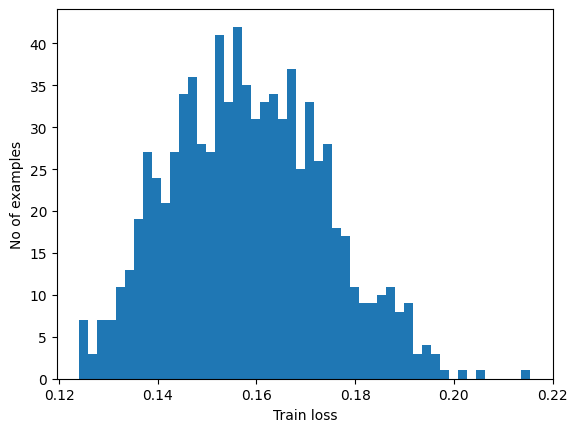

Threshold:  0.17398642654685023
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


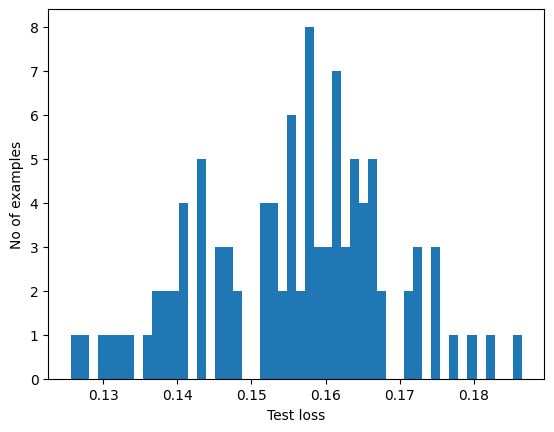

[Timestamp('2019-01-01 00:00:00'), Timestamp('2021-01-01 00:00:00')]


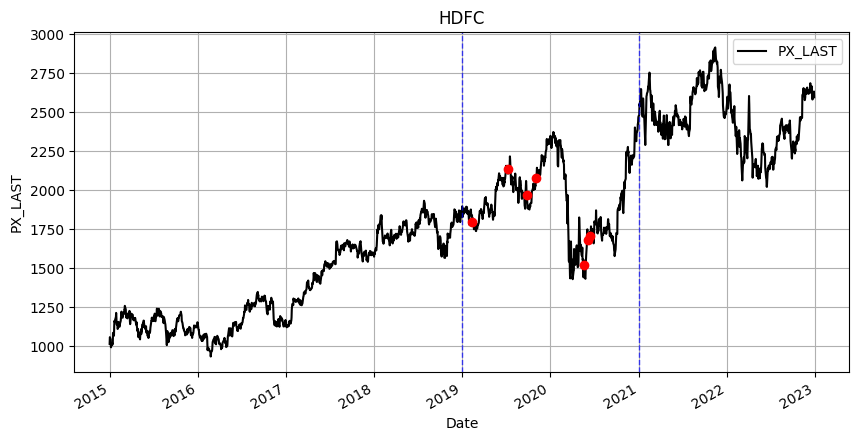

Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - loss: 0.3143 - val_loss: 0.2091
Epoch 2/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - loss: 0.2106 - val_loss: 0.2021
Epoch 3/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.2032 - val_loss: 0.1910
Epoch 4/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - loss: 0.1951 - val_loss: 0.1815
Epoch 5/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - loss: 0.1894 - val_loss: 0.1810
Epoch 6/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - loss: 0.1824 - val_loss: 0.1736
Epoch 7/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.1785 - val_loss: 0.1713
Epoch 8/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - loss: 0.1773 - val_loss: 0.1675
Epoch 9/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 0.1737 - val_loss: 0.1642
Epoch 10/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.1697 - val_loss: 0.1657
Epoch 11/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - loss: 0.1698 - val_loss: 0.1641
Epoch 12/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - loss: 0.1689

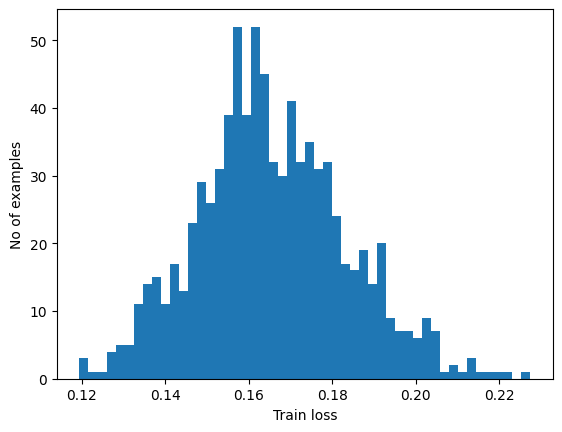

Threshold:  0.18344966294140905
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


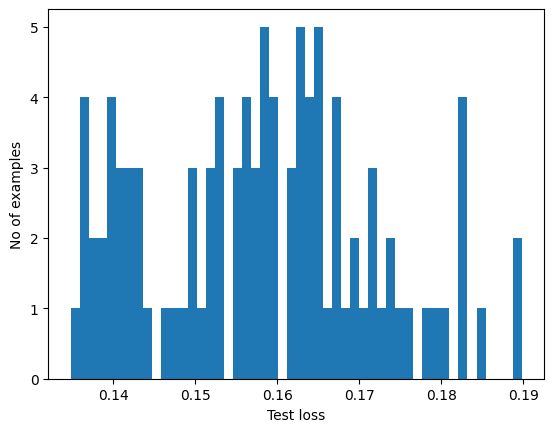

[Timestamp('2019-01-01 00:00:00'), Timestamp('2021-01-01 00:00:00')]


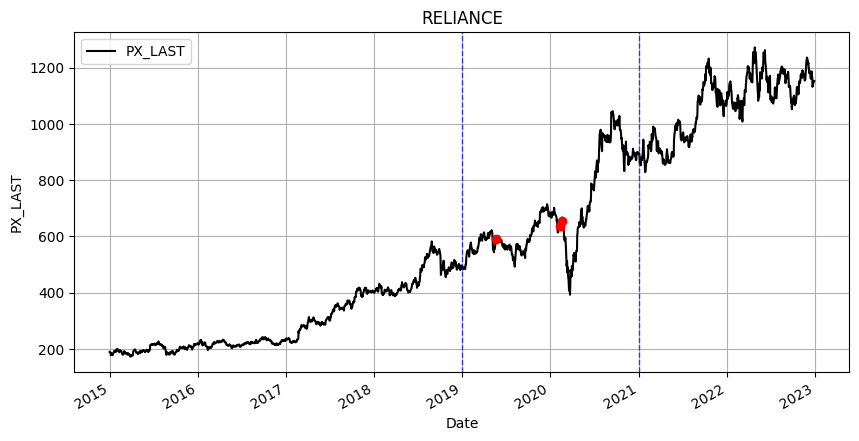

Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step - loss: 0.3058 - val_loss: 0.2086
Epoch 2/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.2063 - val_loss: 0.1931
Epoch 3/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.1970 - val_loss: 0.1839
Epoch 4/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 0.1873 - val_loss: 0.1751
Epoch 5/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.1813 - val_loss: 0.1743
Epoch 6/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - loss: 0.1765 - val_loss: 0.1701
Epoch 7/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - loss: 0.1738 - val_loss: 0.1690
Epoch 8/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - loss: 0.1709 - val_loss: 0.1671
Epoch 9/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 0.1684 - val_loss: 0.1641
Epoch 10/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.1677 - val_loss: 0.1629
Epoch 11/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.1657 - val_loss: 0.1615
Epoch 12/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - loss: 0.1644 - v

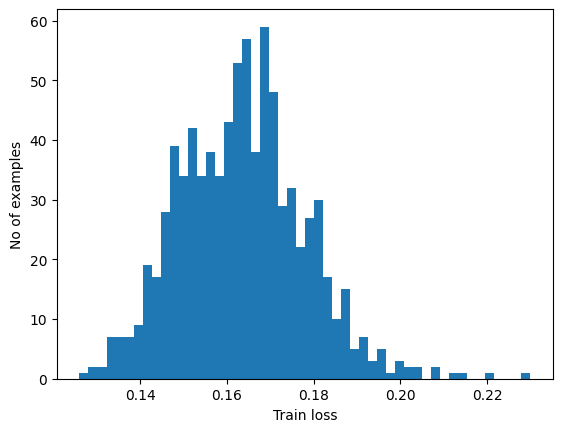

Threshold:  0.17804258141600482
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


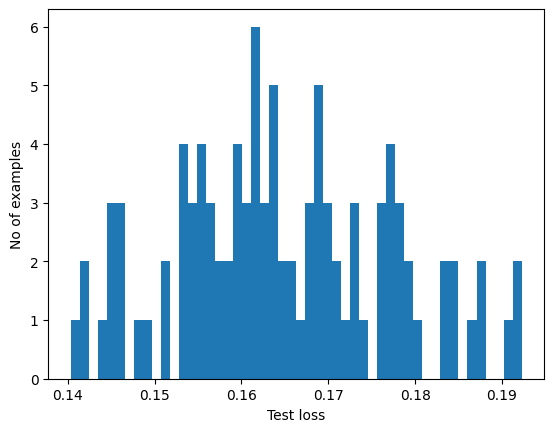

[Timestamp('2019-01-01 00:00:00'), Timestamp('2021-01-01 00:00:00')]


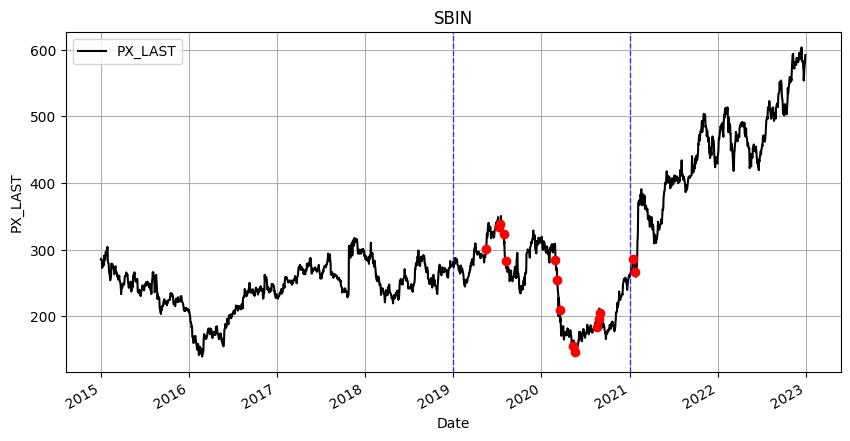

In [110]:
#TICKERS = CURR_UNIVERSE
TICKERS = ['HDFC', 'RELIANCE', 'SBIN']
PRICE_TYPE = 'PX_LAST'
#COLS_TO_KEEP = ['PX_LAST','PX_OPEN', 'PX_HIGH', 'PX_LOW', 'volume_max_ratio' ]
#COLS_TO_KEEP = ['PX_LAST','PX_OPEN', 'PX_HIGH', 'PX_LOW', 'volume_ratio' ]
#COLS_TO_KEEP = ['returnsClose','returnsOpen', 'returnsHigh', 'returnsLow', 'volume_max_ratio' ]
COLS_TO_KEEP = [ 'volume_max_ratio', 'Price_Spread', 'Body_Size', 'Upper_Shadow', 'Lower_Shadow', 'Close_Open_Gap',
                'SMA_5', 'SMA_20', 'MACD', 'MACD_Signal', 'RSI', 'ATR', 'Bollinger_Upper', 'Bollinger_Lower', 'MFR', 'MFI' ]
# input_dim = 30
# latent_dim = 8
MODEL_INFO = ""
returnsAtAnomalies = {}

for ticker in TICKERS:
  try:
    prices = getStockPriceVolumeData(ticker)

    X, index_map = normalize_window_roll(prices,30,5,COLS_TO_KEEP)
    startTest = date(2019, 1, 1)
    endTest = date(2021, 1, 1)

    startVal = date(2014, 1, 1)
    endVal = date(2018, 1, 1)

    X_train, X_val, X_test, index_train, index_val, index_test = split_data(X, index_map, startTest, endTest, startVal, endVal)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')

    ########################### CHANGE MDOEL HERE ###########################

    #autoencoder = AnomalyDetectorNN(30, 1)
    autoencoder = LSTMAutoencoder(30, len(COLS_TO_KEEP), 16)
    autoencoder.compile(optimizer='adam', loss='mae')

    history = autoencoder.fit(X_train,X_train, epochs=80,
                        validation_data=(X_val, X_val),
                        batch_size=16,
                        callbacks=[early_stopping])

    reconstructions = autoencoder.predict(X_train)
    train_loss = tf.reduce_mean(tf.keras.losses.mae(reconstructions, X_train), axis=1)

    plt.hist(train_loss[None,:], bins=50)
    plt.xlabel("Train loss")
    plt.ylabel("No of examples")
    plt.show()

    threshold = np.mean(train_loss) + np.std(train_loss)
    #threshold = np.max(train_loss)
    print("Threshold: ", threshold)

    reconstructions = autoencoder.predict(X_test)
    test_loss = tf.reduce_mean(tf.keras.losses.mae(reconstructions, X_test), axis=1)

    plt.hist(test_loss[None, :], bins=50)
    plt.xlabel("Test loss")
    plt.ylabel("No of examples")
    plt.show()

    preds = predict(autoencoder, X_test, threshold)

    anomalousIndexIds  = np.where(preds == False)[0]

    dotDates = [index_test[i][-1] for i in anomalousIndexIds]
    plotPrice(ticker, PRICE_TYPE, date(2015, 1, 1), None, dotDates, lineDates=[startTest, endTest], saveSuffix=autoencoder.__class__.__name__ + MODEL_INFO)

    returns = calculate_returns(prices, dotDates)
    returnsAtAnomalies[ticker] = returns

  except Exception as e:
    print(f"Error processing {ticker}: {e}")

returnsAtAnomaliesDf = pd.concat(
    [df.assign(Ticker=ticker) for ticker, df in returnsAtAnomalies.items()],
    ignore_index=True
)
results = evaluate_predictions(returnsAtAnomaliesDf)
results.to_csv('results' + autoencoder.__class__.__name__ + MODEL_INFO + '.csv')


In [ ]:
evaluate_predictions(returnsAtAnomaliesDf)

In [111]:
results

,Ticker,Total Anomalies,|3M Return| > 10%,|6M Return| > 10%,|3M Return| > 20%,|6M Return| > 20%
0,HDFC,7,3,6,0,5
1,RELIANCE,3,0,3,0,2
2,SBIN,15,14,10,7,9


#Direction of trade

In [ ]:
import pandas as pd
import numpy as np

def signalFromAnomaly(data, anomalyDates):
    """
    Generate trading signals based on anomalies using trend & mean reversion filters.

    Parameters:
    data (pd.DataFrame): DataFrame with 'Close' prices and date index.
    anomalyDates (list): List of dates (as strings) where anomalies were detected.

    Returns:
    pd.DataFrame: Original DataFrame with a new 'Signal' column.
    """
    df = data.copy()

    # Ensure the index is a datetime index
    df.index = pd.to_datetime(df.index)

    # Compute Moving Averages
    df['SMA_5'] = df['PX_LAST'].rolling(window=5).mean()
    df['SMA_20'] = df['PX_LAST'].rolling(window=20).mean()

    # Compute Bollinger Bands
    rolling_mean = df['PX_LAST'].rolling(window=20).mean()
    rolling_std = df['PX_LAST'].rolling(window=20).std()
    df['BB_Upper'] = rolling_mean + (2 * rolling_std)
    df['BB_Lower'] = rolling_mean - (2 * rolling_std)

    # Compute RSI manually
    delta = df['PX_LAST'].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    avg_gain = pd.Series(gain).rolling(window=14, min_periods=1).mean()
    avg_loss = pd.Series(loss).rolling(window=14, min_periods=1).mean()

    rs = avg_gain / (avg_loss + 1e-10)  # Avoid division by zero
    df['RSI'] = 100 - (100 / (1 + rs))

    # Compute Momentum (5-day return)
    df['Momentum'] = df['PX_LAST'].pct_change(periods=5)

    # Initialize Signal Column
    df['Signal'] = 0

    # Generate Signals
    for date in anomalyDates:
        date = pd.to_datetime(date)
        if date in df.index:
            sma5 = df.loc[date, 'SMA_5']
            sma20 = df.loc[date, 'SMA_20']
            rsi = df.loc[date, 'RSI']
            close = df.loc[date, 'PX_LAST']
            upper_bb = df.loc[date, 'BB_Upper']
            lower_bb = df.loc[date, 'BB_Lower']
            momentum = df.loc[date, 'Momentum']

            # Trend-Following: Buy if SMA5 > SMA20 (Uptrend), Sell if SMA5 < SMA20 (Downtrend)
            if sma5 > sma20:
                signal = 1  # Buy
            elif sma5 < sma20:
                signal = -1  # Sell
            else:
                signal = 0  # No clear trend

            # Mean Reversion Filters
            if close >= upper_bb or rsi > 70:
                signal = -1  # Overbought, Sell
            elif close <= lower_bb or rsi < 30:
                signal = 1  # Oversold, Buy

            # Momentum Confirmation (Only take trade if past returns support it)
            if momentum > 0 and signal == 1:
                signal = 0  # Avoid buying into strong price rise
            elif momentum < 0 and signal == -1:
                signal = 0  # Avoid selling into strong decline

            df.loc[date, 'Signal'] = signal

    return df

#Quality of Trade

In [109]:
import pandas as pd

def calculate_returns(df, anomaly_dates, months=[3, 6]):
    """
    Compute 3-month and 6-month returns from anomaly dates, selecting the next available date if missing.

    Parameters:
    df (pd.DataFrame): DataFrame with 'PX_LAST' prices and datetime index.
    anomaly_dates (list): List of anomaly dates (as strings or datetime).
    months (list): List of months for return calculation (default: [3, 6]).

    Returns:
    pd.DataFrame: Table with anomaly dates, 3M & 6M returns.
    """
    df = df.copy()
    df.index = pd.to_datetime(df.index)  # Ensure index is datetime
    sorted_dates = df.index.sort_values()  # Ensure index is sorted
    results = []

    for date in anomaly_dates:
        anomaly_date = pd.to_datetime(date)
        if anomaly_date not in df.index:
            continue  # Skip if anomaly date is missing

        price_at_anomaly = df.loc[anomaly_date, "PX_LAST"]
        row = {"Anomaly Date": anomaly_date, "Price at Anomaly": price_at_anomaly}

        for m in months:
            future_date = anomaly_date + pd.DateOffset(months=m)

            # Find the next available date if the exact future date is missing
            future_idx = sorted_dates.searchsorted(future_date)
            if future_idx < len(sorted_dates):  # Ensure index is within bounds
                adjusted_future_date = sorted_dates[future_idx]
                future_price = df.loc[adjusted_future_date, "PX_LAST"]
                return_m = (future_price - price_at_anomaly) * 100 / price_at_anomaly
                row[f"{m}M Return"] = return_m
            else:
                row[f"{m}M Return"] = None  # No future data available

        results.append(row)

    return pd.DataFrame(results)


import pandas as pd
import numpy as np

def evaluate_predictions(returns_df):
    """
    Compute statistics to evaluate anomaly-based predictions.

    Parameters:
    returns_df (pd.DataFrame): DataFrame containing 'Ticker', 'Anomaly Date', '3M Return', '6M Return'.

    Returns:
    pd.DataFrame: Summary table with counts of strong movements.
    """
    stats = []

    for ticker, group in returns_df.groupby("Ticker"):
        total_anomalies = len(group)

        # Count occurrences where absolute return exceeds threshold
        count_abs_3m_10 = (group["3M Return"].abs() > 10).sum()
        count_abs_6m_10 = (group["6M Return"].abs() > 10).sum()
        count_abs_3m_20 = (group["3M Return"].abs() > 20).sum()
        count_abs_6m_20 = (group["6M Return"].abs() > 20).sum()

        stats.append({
            "Ticker": ticker,
            "Total Anomalies": total_anomalies,
            "|3M Return| > 10%": count_abs_3m_10,
            "|6M Return| > 10%": count_abs_6m_10,
            "|3M Return| > 20%": count_abs_3m_20,
            "|6M Return| > 20%": count_abs_6m_20
        })

    return pd.DataFrame(stats)


#Volume normalization (DON)

#Remove index component (NEED INDEX TIME SERIES)

#Use all features (DONE)

# Rough

In [ ]:
TICKER = 'SBIN'
PRICE_TYPE = 'PX_LAST'
prices = getStockPriceVolumeData(TICKER, start=date(2010, 1, 1))[PRICE_TYPE]
prices.rename('price', inplace=True)
prices.dropna(inplace=True) # only 2 nan dates for reliance for eg.

In [ ]:
# should we smoothen the data ?
X, index_map = normalize_window_roll(prices,30)

In [ ]:
print(X.shape)
print(prices.shape)
print(len(index_map))

In [ ]:
train_size = int(0.7*X.shape[0])
test_size = int(0.1*X.shape[0])
val_size = int(0.2*X.shape[0])

X_train = X[:train_size]
X_val = X[train_size+test_size:train_size+val_size+test_size]
X_test = X[train_size:train_size+test_size]

val_index_offset = train_size + test_size
test_index_offset = train_size
#X_val = X[train_size+test_size:train_size+test_size+val_size]

In [ ]:
'''
Training the model: The autoencoder is trained using the stock market data using the fit function.
An EarlyStopping callback is added to stop the training if the validation loss does not improve for 2 consecutive epochs.
'''
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=2,
                                                  mode='min')
autoencoder.compile(optimizer='adam', loss='mae')

history = autoencoder.fit(X_train,X_train, epochs=80,
                    validation_data=(X_val, X_val),
                    batch_size=16,
                    callbacks=[early_stopping])

In [ ]:
#Source: https://www.tensorflow.org/tutorials/generative/autoencoder
reconstructions = autoencoder.predict(X_train)
train_loss = tf.keras.losses.mae(reconstructions, X_train)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

In [ ]:
np.mean(train_loss)

In [ ]:
reconstructions = autoencoder.predict(X_test)
test_loss = tf.keras.losses.mae(reconstructions, X_test)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
preds = predict(autoencoder, X_test, threshold)

In [ ]:
preds

In [ ]:
anomalous_test_data = X_test[np.where(preds==False)]

In [ ]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

for p in [1,10,20]:
  plt.plot(anomalous_test_data[p], 'b')
  plt.plot(np.arange(0,X.shape[1]),decoded_data[p], 'r')
  plt.fill_between(np.arange(X.shape[1]), decoded_data[p], anomalous_test_data[p], color='lightcoral')
  plt.legend(labels=["Input", "Reconstruction", "Error"])
  plt.show()

#Visualize on original price plot

In [ ]:
anomalousIndexIds  = np.where(preds == False)[0]
anomalousIndexIds = [ int(test_index_offset + id) for id in anomalousIndexIds ]

In [ ]:
#dotDates = [date for i in anomalousIndexIds for date in index_map[i]]
dotDates = [index_map[i][0] for i in anomalousIndexIds]

In [ ]:
dotDates

In [ ]:
plotPrice(TICKER, 'PX_LAST', date(2013, 1, 1), None, dotDates, lineDates=[index_map[val_index_offset][0], index_map[test_index_offset][0]])

In [ ]:
ticker

In [ ]:
prices.index[test_index_offset]

In [ ]:
val_index_offset

In [ ]:
test_index_offset